# Using the waveguide plugin to analyze waveguide modes

This notebook demosntrates the use of the waveguide plugin to quickly set-up waveguide simulations from usual geometries.

In [1]:
import tidy3d as td
import tidy3d.web as web
from tidy3d.plugins import waveguide

import numpy as np
from matplotlib import pyplot

In [2]:
# Media used in the examples
si = td.material_library["cSi"]["Li1993_293K"]
sio2 = td.material_library["SiO2"]["Horiba"]

## Strip and Rib Geometries

The class `RectangularDielectric` allows the creation of a variety of dielectric waveguide geometries common in integrated photonics.

First we take a look at a strip silicon waveguide and plot the fundamental quasi-TE and quasi-TM modes, along with their effective indices:

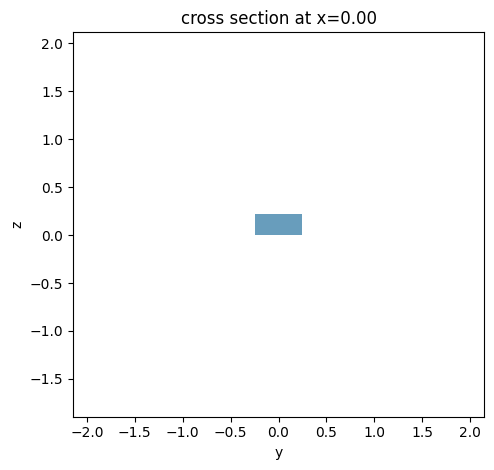

In [3]:
strip = waveguide.RectangularDielectric(
    wavelength=1.55,
    core_width=0.5,
    core_thickness=0.22,
    core_medium=si,
    clad_medium=sio2,
    mode_spec=td.ModeSpec(num_modes=2, precision="double", group_index_step=True),
)

# Take a look at the waveguide cross-section
_ = strip.plot_structures(x=0)

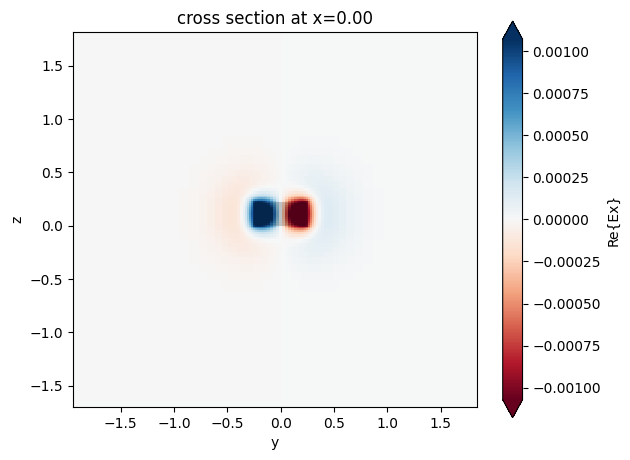

In [4]:
strip.plot_field("Ex", mode_index=0)

Effective indices: [[2.53287852 1.89256577]]
Effective mode areas (µm²): [[0.18517123 0.30873644]]
Group index: [[4.17741743 4.18908857]]


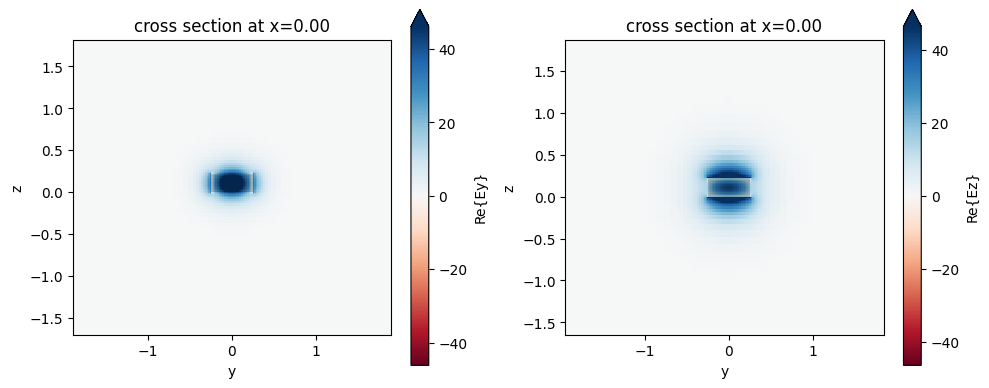

In [5]:
# Mode data
print(f"Effective indices: {strip.n_eff.values}")
print(f"Effective mode areas (µm²): {strip.mode_area.values}")
print(f"Group index: {strip.n_group.values}")

fig, ax = pyplot.subplots(1, 2, figsize=(10, 4), tight_layout=True)

# quasi-TE mode
strip.plot_field("Ey", mode_index=0, ax=ax[0])

# quasi-TM mode
strip.plot_field("Ez", mode_index=1, ax=ax[1])

It is possible to define waveguides with different substrate and cladding, angled sidewalls, and rib geometry:

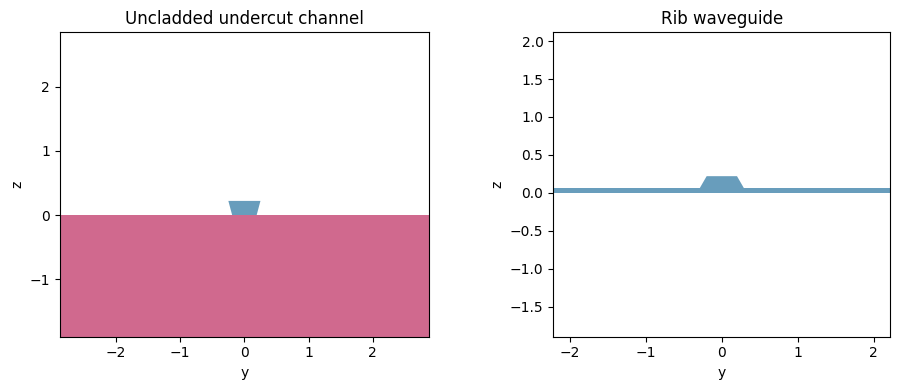

In [6]:
fig, ax = pyplot.subplots(1, 2, figsize=(10, 4), tight_layout=True)

undercut = strip = waveguide.RectangularDielectric(
    wavelength=1.55,
    core_width=0.5,
    core_thickness=0.22,
    sidewall_angle=-np.pi / 12,
    core_medium=si,
    clad_medium=td.Medium(permittivity=1.0),
    box_medium=sio2,
)

undercut.plot_structures(x=0, ax=ax[0])
_ = ax[0].set_title("Uncladded undercut channel")

rib = strip = waveguide.RectangularDielectric(
    wavelength=1.55,
    core_width=0.4,
    core_thickness=0.22,
    slab_thickness=0.07,
    sidewall_angle=np.pi / 6,
    core_medium=si,
    clad_medium=sio2,
)

rib.plot_structures(x=0, ax=ax[1])
_ = ax[1].set_title("Rib waveguide")

## FDTD Simulation

The waveguide structures can be used in Tidy3D simulations as conventinal structures.  The origin, lenght, and orientation of the waveguides can be selected at creation to fit the most common simulation configurations.

In the following example, we simulate the effect of directly coupling strip and rib geometries without any tapering and compare the result with the modal overlap calclulation between the two modes.

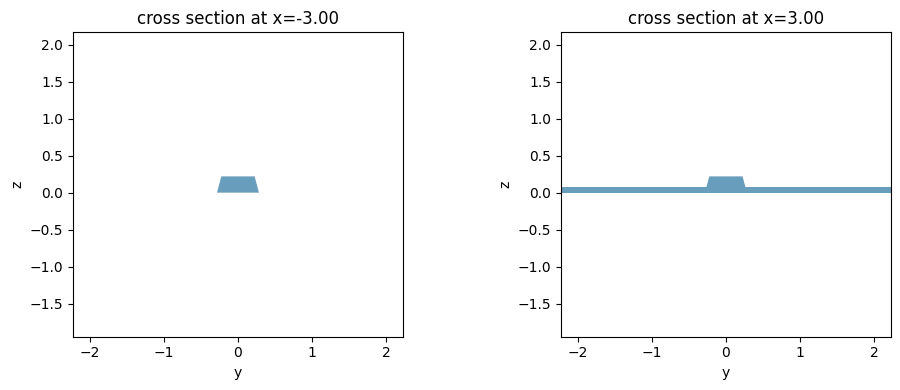

In [7]:
length = 6.0

strip, rib = [
    waveguide.RectangularDielectric(
        wavelength=np.linspace(1.5, 1.6, 11),
        core_width=0.45,
        core_thickness=0.22,
        core_medium=si,
        clad_medium=sio2,
        slab_thickness=0.07 if slab else 0,
        length=length,
        origin=(0.5 * length if slab else -0.5 * length, 0, 0),
        sidewall_angle=np.pi / 12,
    ) for slab in (False, True)
]

fig, ax = pyplot.subplots(1, 2, figsize=(10, 4), tight_layout=True)
strip.plot_structures(x=-0.5 * length, ax=ax[0])
rib.plot_structures(x=0.5 * length, ax=ax[1])

pyplot.show()

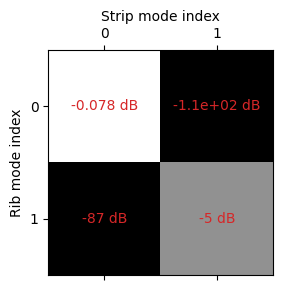

In [8]:
# Calculate the mode overlap between waveguides
overlap = strip.mode_solver.data.outer_dot(rib.mode_solver.data, False)

# Show the overlap at the central frequency
f = strip.mode_solver.freqs[strip.wavelength.size // 2]

fig, ax = pyplot.subplots(1, 1, figsize=(3, 3), tight_layout=True)

ax.matshow(overlap.sel(f=f).abs.values, cmap="gray")
ax.grid(False)

for mi0 in overlap.coords["mode_index_0"]:
    for mi1 in overlap.coords["mode_index_1"]:
        ovl_dB = 20 * np.log10(overlap.sel(f=f, mode_index_0=mi0, mode_index_1=mi1).abs.item())
        ax.text(mi0, mi1, f"{ovl_dB:.2g} dB", ha="center", va="center", color="tab:red")

ax.set_ylabel("Rib mode index")
ax.set_xlabel("Strip mode index")
ax.xaxis.set_label_position('top') 

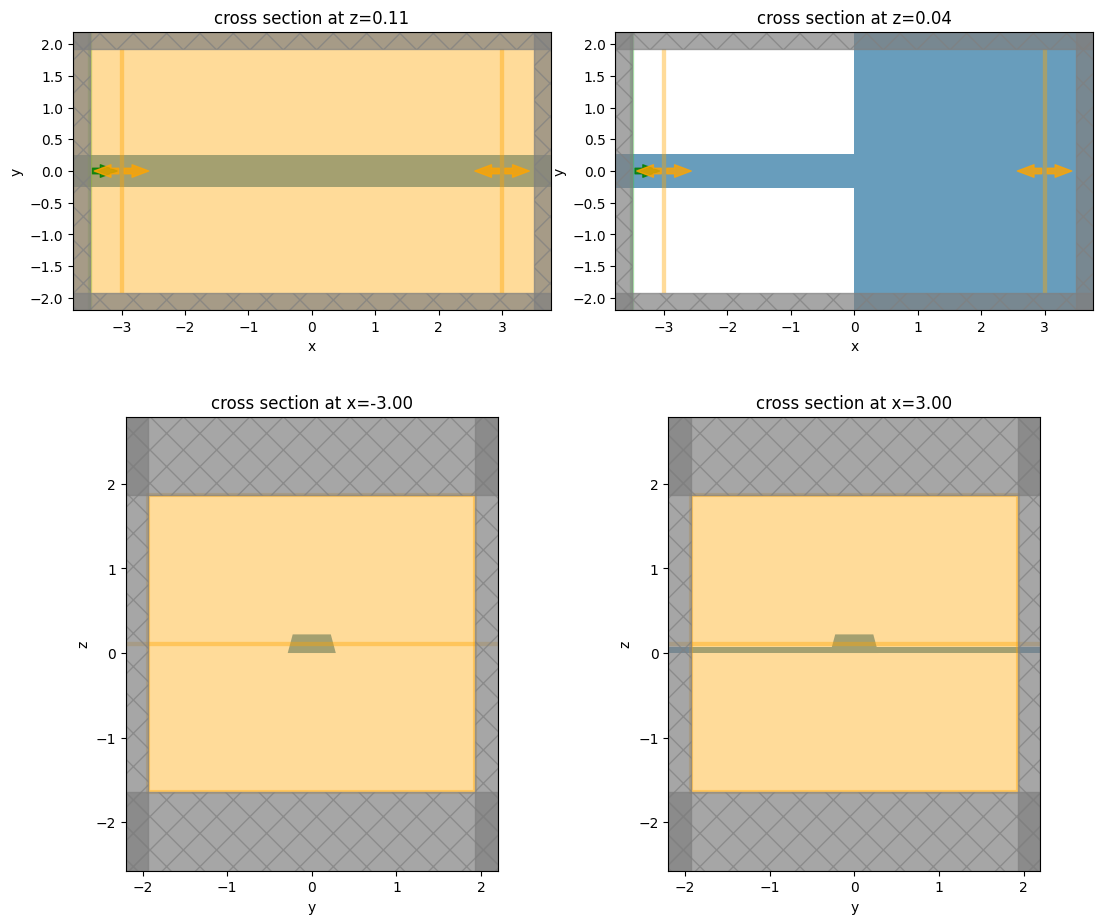

In [9]:
freqs = strip.mode_solver.freqs
source_time = td.GaussianPulse(freq0=0.5 * (freqs[0] + freqs[-1]), fwidth=abs(freqs[0] - freqs[-1]))

src_gap = 0.5
mode_src = td.ModeSource(
    center=(-0.5 * length - src_gap, 0, 0),
    size=(0, td.inf, td.inf),
    source_time=source_time,
    num_freqs=5,
    direction="+",
    mode_spec=strip.mode_spec,
    mode_index=0,
)

strip_mnt = strip.mode_solver.to_monitor(freqs=freqs, name="strip")

rib_mnt = rib.mode_solver.to_monitor(freqs=freqs, name="rib")

field_mnt = td.FieldMonitor(
    center=(0, 0, 0.5 * strip.core_thickness),
    size=(td.inf, td.inf, 0),
    freqs=freqs,
    name="field",
)

sim_size = (length + 2 * src_gap, strip.width, strip.height)
sim_center = (0, 0, strip.mode_solver.plane.center[2])

sim = td.Simulation(
    size=sim_size,
    center=sim_center,
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=20),
    structures=strip.structures + rib.structures,
    sources=[mode_src],
    monitors=[strip_mnt, rib_mnt, field_mnt],
    run_time=1e-12,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
)

fig, ax = pyplot.subplots(2, 2, figsize=(11, 10), tight_layout=True)
sim.plot(z=0.5 * strip.core_thickness, ax=ax[0, 0])
sim.plot(z=0.5 * rib.slab_thickness, ax=ax[0, 1])
sim.plot(x=-0.5 * length, ax=ax[1, 0])
sim.plot(x=0.5 * length, ax=ax[1, 1])
pyplot.show()

In [10]:
# Run the simulation and download the resulting data
data = web.run(sim, task_name="untapered", verbose=True)

[16:32:58] Created task 'untapered' with task_id 'fdve-28ced38d-a679-4142-bb90-9aded21b7c8dv1'.       ]8;id=179740;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=424665;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#139\139]8;;\

           View task using web UI at                                                                  ]8;id=722741;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=239250;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#141\141]8;;\
           ]8;id=366408;https://tidy3d.simulation.cloud/workbench?taskId=fdve-28ced38d-a679-4142-bb90-9aded21b7c8dv1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=599236;https://tidy3d.simulation.cloud/workbench?taskId=fdve-28ced38d-a679-4142-bb90-9aded21b7c8dv1\taskId]8;;\]8;id=366408;https://tidy3d.simulation.cloud/workbench?taskId=fdve-28ced38d-a679-4142-bb90-9aded21b7c8dv1\=]8;;\]8;id=99761;https://tidy3d.simulation.cloud/workbench?taskId=fdve-28ced38d-a679-4142-bb90-9aded21b7c8dv1\fdve]8;;\]8;id=366408;https://tidy3d.simulation.cloud/workbench?taskId=fdve-28ced38d-a679-4142-bb90-9aded21b7c8dv1\-28ced38d-a679-4142-bb90-9aded21b7c8]8;;\              
           ]8;id=366408;https://tidy3d.simulation.cloud/workbench?taskId=fdve-28ced38d-a679-4142-bb90-9aded21b7c8dv1\dv1']8;;\.                                                                                                   

Output()

[16:33:01] status = queued                                                                            ]8;id=350450;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=418921;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#271\271]8;;\

Output()

[16:33:03] status = preprocess                                                                        ]8;id=837765;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=565957;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#265\265]8;;\

[16:33:14] Maximum FlexCredit cost: 0.054. Use 'web.real_cost(task_id)' to get the billed FlexCredit  ]8;id=460208;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=171988;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#288\288]8;;\
           cost after a simulation run.                                                                            

           starting up solver                                                                         ]8;id=463581;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=916149;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#292\292]8;;\

           running solver                                                                             ]8;id=787288;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=178955;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#302\302]8;;\

Output()

[16:33:31] early shutoff detected, exiting.                                                           ]8;id=112894;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=508379;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#316\316]8;;\

           status = postprocess                                                                       ]8;id=538957;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=2164;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#333\333]8;;\

Output()

[16:34:01] status = success                                                                           ]8;id=612585;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=265262;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#340\340]8;;\

Output()

[16:34:19] loading SimulationData from simulation_data.hdf5                                           ]8;id=934796;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=615043;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#512\512]8;;\

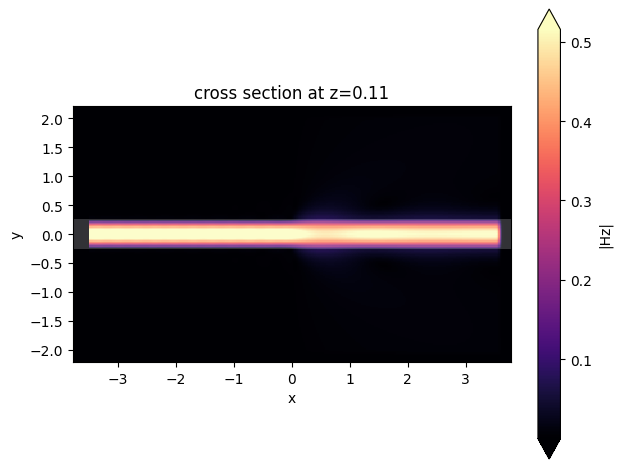

In [11]:
_ = data.plot_field("field", "Hz", val="abs", f=f)

Looking at the power transmisison, we see almost the same result as obtained from the overlap calculation:

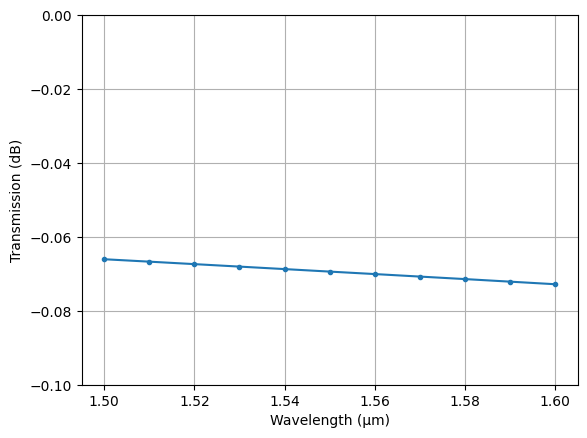

In [12]:
rib_transmission = data["rib"].amps.sel(direction="+", mode_index=0)
fig, ax = pyplot.subplots(1, 1)
ax.plot(rib.wavelength, 20 * np.log10(rib_transmission.abs.values), '.-')
ax.set(
    xlabel="Wavelength (μm)",
    ylabel="Transmission (dB)",
    ylim=(-0.1, 0),
)
ax.grid()

We can look at the first quasi-TM mode as well:

[16:34:20] Created task 'untapered_tm' with task_id 'fdve-cc1467cf-b55d-413d-aa5e-7ab1e7d24bb4v1'.    ]8;id=406562;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=520916;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#139\139]8;;\

           View task using web UI at                                                                  ]8;id=354609;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=297280;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#141\141]8;;\
           ]8;id=204692;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cc1467cf-b55d-413d-aa5e-7ab1e7d24bb4v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=931471;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cc1467cf-b55d-413d-aa5e-7ab1e7d24bb4v1\taskId]8;;\]8;id=204692;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cc1467cf-b55d-413d-aa5e-7ab1e7d24bb4v1\=]8;;\]8;id=35388;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cc1467cf-b55d-413d-aa5e-7ab1e7d24bb4v1\fdve]8;;\]8;id=204692;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cc1467cf-b55d-413d-aa5e-7ab1e7d24bb4v1\-cc1467cf-b55d-413d-aa5e-7ab1e7d24bb]8;;\              
           ]8;id=204692;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cc1467cf-b55d-413d-aa5e-7ab1e7d24bb4v1\4v1']8;;\.                                                                                                   

Output()

[16:34:23] status = queued                                                                            ]8;id=61677;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=862101;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#271\271]8;;\

Output()

[16:34:25] status = preprocess                                                                        ]8;id=690739;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=830360;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#265\265]8;;\

[16:34:35] Maximum FlexCredit cost: 0.054. Use 'web.real_cost(task_id)' to get the billed FlexCredit  ]8;id=298711;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=538108;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#288\288]8;;\
           cost after a simulation run.                                                                            

           starting up solver                                                                         ]8;id=670004;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=877104;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#292\292]8;;\

           running solver                                                                             ]8;id=25094;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=16100;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#302\302]8;;\

Output()

[16:34:52] early shutoff detected, exiting.                                                           ]8;id=851326;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=253704;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#316\316]8;;\

           status = postprocess                                                                       ]8;id=825597;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=236385;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#333\333]8;;\

Output()

[16:35:16] status = success                                                                           ]8;id=886609;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=153547;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#340\340]8;;\

Output()

[16:35:22] loading SimulationData from simulation_data.hdf5                                           ]8;id=149686;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=529063;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#512\512]8;;\

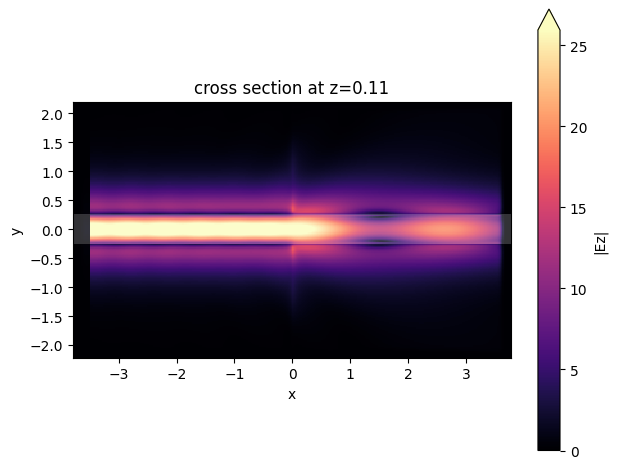

In [13]:
# mode_src_tm = mode_src.copy(update={"mode_index": 1})
mode_src_tm = td.ModeSource(
    center=(-0.5 * length - src_gap, 0, 0),
    size=(0, td.inf, td.inf),
    source_time=source_time,
    num_freqs=5,
    direction="+",
    mode_spec=strip.mode_spec,
    mode_index=1,
)

sim_tm = sim.copy(update={"sources": [mode_src_tm]})
data_tm = td.web.run(sim_tm, task_name="untapered_tm", verbose=True)
_ = data_tm.plot_field("field", "Ez", val="abs", f=f)

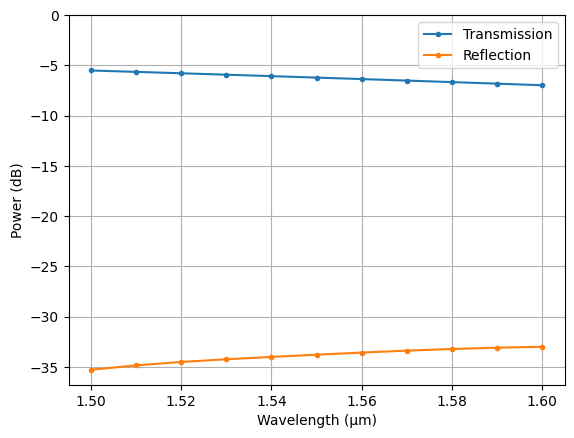

In [14]:
rib_transmission = data_tm["rib"].amps.sel(direction="+", mode_index=1)
strip_reflection = data_tm["strip"].amps.sel(direction="-", mode_index=1)

fig, ax = pyplot.subplots(1, 1)
ax.plot(rib.wavelength, 20 * np.log10(rib_transmission.abs.values), '.-', label="Transmission")
ax.plot(rib.wavelength, 20 * np.log10(strip_reflection.abs.values), '.-', label="Reflection")
ax.set(
    xlabel="Wavelength (μm)",
    ylabel="Power (dB)",
    ylim=(None, 0),
)
ax.legend()
ax.grid()

## Waveguide Bends

Waveguide bends can be modeled by setting the appropriate attributes in the mode specification.

Complex effective index: 2.53244+4.25036e-05j


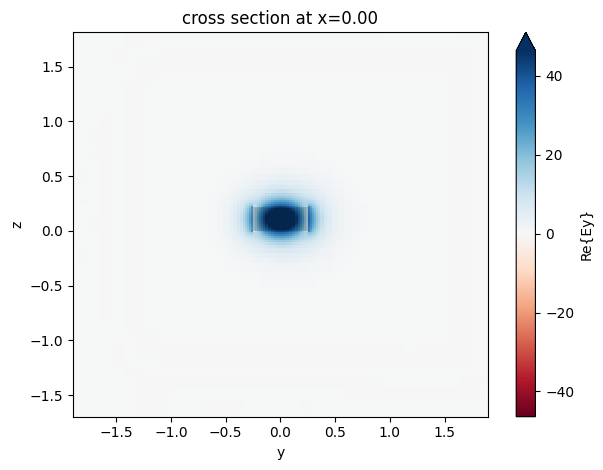

In [15]:
bend = waveguide.RectangularDielectric(
    wavelength=1.55,
    core_width=0.5,
    core_thickness=0.22,
    core_medium=si,
    clad_medium=sio2,
    mode_spec=td.ModeSpec(
        num_modes=1,
        bend_radius=5,
        bend_axis=1,
        num_pml=(12, 12),
        precision="double",
    ),
)

fig, ax = pyplot.subplots(1, 1, tight_layout=True)
bend.plot_field("Ey", mode_index=0, ax=ax)

print(f"Complex effective index: {bend.n_complex.item():g}")

Let's create a helper function to convert the imaginary part of the complex effective index into loss in dB/cm:

In [16]:
def loss_dB_per_cm(wg):
    alpha = 2 * np.pi * wg.n_complex.imag / wg.wavelength  # µm⁻¹
    return 1e4 * 20 * np.log10(np.e) * alpha  # dB/cm

print(f"Curvature loss: {loss_dB_per_cm(bend).item():.1f} dB/cm")

Curvature loss: 15.0 dB/cm


We can put it all together to plot loss as a function of bend radius:

In [17]:
radii = 5 * 10 ** np.linspace(0, 1, 10)
bends = [
    waveguide.RectangularDielectric(
        wavelength=1.55,
        core_width=0.5,
        core_thickness=0.22,
        core_medium=si,
        clad_medium=sio2,
        mode_spec=td.ModeSpec(
            num_modes=1,
            bend_radius=radius,
            bend_axis=1,
            num_pml=(12, 12),
            precision="double",
        ),
    ) for radius in radii
]

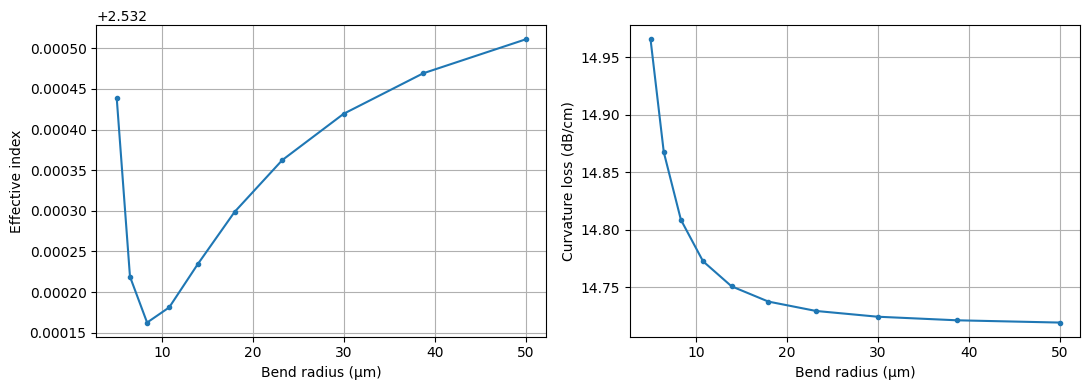

In [18]:
fig, ax = pyplot.subplots(1, 2, figsize=(11, 4), tight_layout=True)

ax[0].plot(radii, [wg.n_eff.item() for wg in bends], ".-")
ax[0].set_xlabel("Bend radius (μm)")
ax[0].set_ylabel("Effective index")
ax[0].grid()

ax[1].plot(radii, [loss_dB_per_cm(wg).item() for wg in bends], ".-")
ax[1].set_xlabel("Bend radius (μm)")
ax[1].set_ylabel("Curvature loss (dB/cm)")
ax[1].grid()

## Coupled Waveguides

The `RectangularDielectric` class supports modeling coupled waveiguides by passing an array of core widths (and a corresponding array of gaps between adjacent cores).

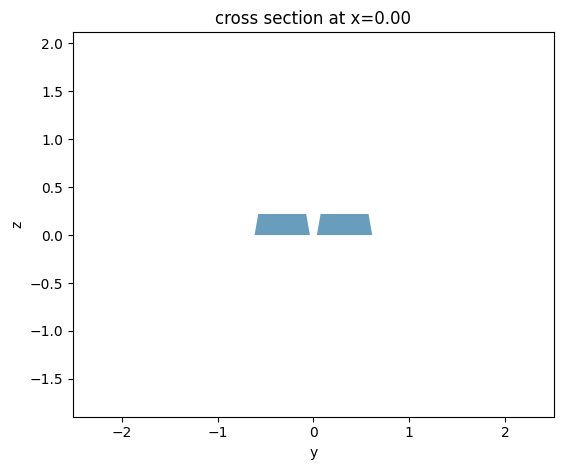

In [19]:
coupled = waveguide.RectangularDielectric(
    wavelength=1.55,
    core_width=(0.5, 0.5),
    core_thickness=0.22,
    core_medium=si,
    clad_medium=sio2,
    gap = 0.15,
    sidewall_angle=np.pi / 18,
    mode_spec=td.ModeSpec(
        num_modes=4,
        precision="double",
    ),
)

_ = coupled.plot_structures(x=0)

Effective indices: [[2.58790025 2.55348271 1.98156471 1.85005072]]
Effective mode areas (µm²): [[0.36718224 0.35510481 0.60730776 0.58347975]]


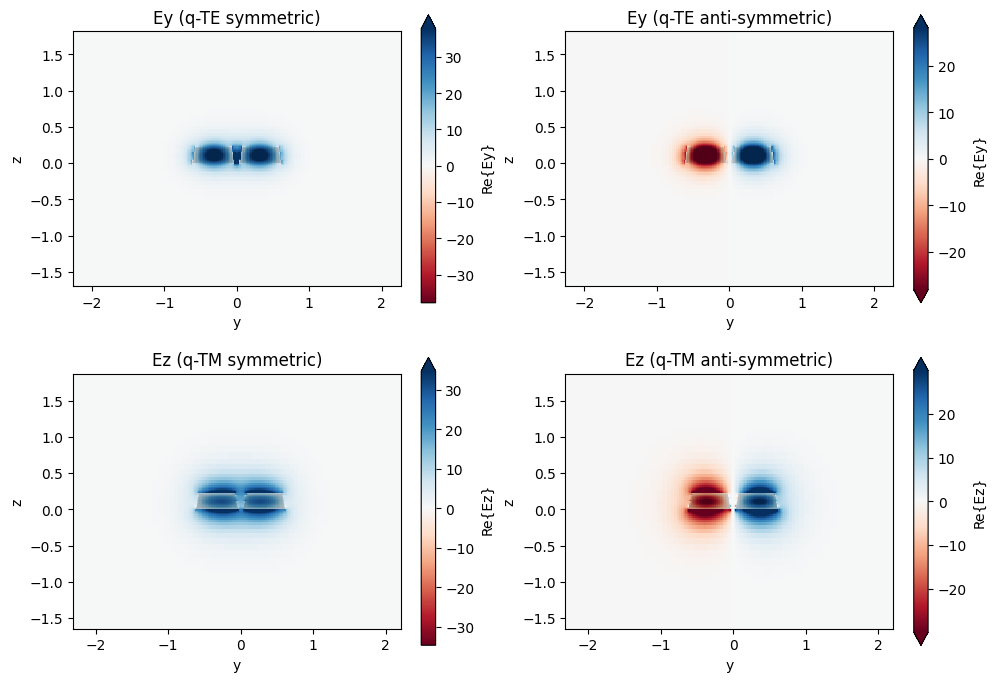

In [20]:
# Mode data
print(f"Effective indices: {coupled.n_eff.values}")
print(f"Effective mode areas (µm²): {coupled.mode_area.values}")

fig, ax = pyplot.subplots(2, 2, figsize=(10, 7), tight_layout=True)

coupled.plot_field("Ey", mode_index=0, ax=ax[0, 0])
ax[0, 0].set_title("Ey (q-TE symmetric)")

coupled.plot_field("Ey", mode_index=1, ax=ax[0, 1])
ax[0, 1].set_title("Ey (q-TE anti-symmetric)")

coupled.plot_field("Ez", mode_index=2, ax=ax[1, 0])
ax[1, 0].set_title("Ez (q-TM symmetric)")

coupled.plot_field("Ez", mode_index=3, ax=ax[1, 1])
ax[1, 1].set_title("Ez (q-TM anti-symmetric)")

pyplot.show()

In a similar fashion, vertical slot waveguides can also be simulated easily:

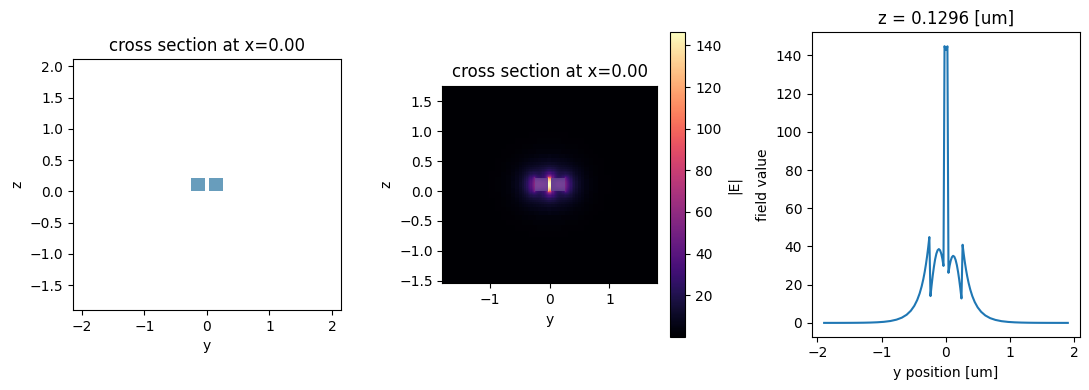

In [21]:
slot = waveguide.RectangularDielectric(
    wavelength=1.55,
    core_width=(0.22, 0.22),
    core_thickness=0.22,
    core_medium=si,
    clad_medium=sio2,
    gap = 0.06,
    mode_spec=td.ModeSpec(
        num_modes=1,
        precision="double",
    ),
)

fig, ax = pyplot.subplots(1, 3, figsize=(11, 4), tight_layout=True)

slot.plot_structures(x=0, ax=ax[0])

# We use 'robust=False' because we're interested in the large values at the slot
slot.plot_field("E", val="abs", ax=ax[1], robust=False)

# Plot a cross-section of the field component normal to the gap
ey = slot.mode_solver.data.Ey
_ = ey.squeeze(drop=True).sel(z=0.55 * slot.core_thickness, method='nearest').real.plot(ax=ax[2])

## Surface Models

Besides using lossy materials for all waveguide regions (core, and upper and lower claddings), it is also possible to create separate medium layers along the sidewalls and top surfaces of the waveguide to model localized losses independently.

In the following models, we exagerate those regions and decrease the domain size only to show a close-up of the resulting geometry.
Decreasing the domain size is only advisable if we know the modes will have properly decaied to insignificant values at the domain boundaries.
Also note that the colors in each plot correspond to different materials.

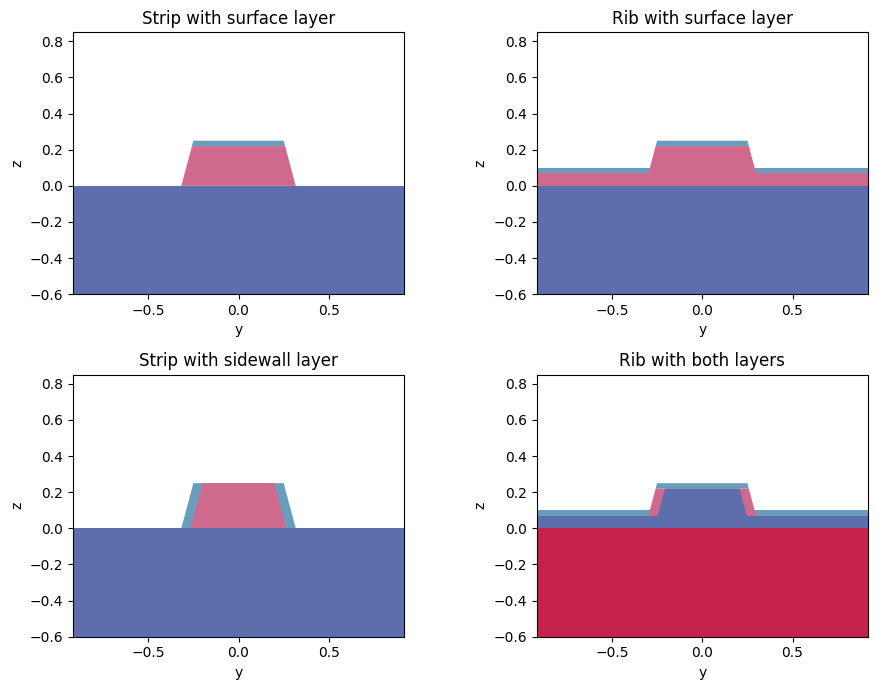

In [22]:
fig, ax = pyplot.subplots(2, 2, figsize=(10, 7), tight_layout=True)

lossy0 = waveguide.RectangularDielectric(
    wavelength=1.55,
    core_width=0.5,
    core_thickness=0.25,
    core_medium=si,
    box_medium=sio2,
    clad_medium=td.Medium(permittivity=1.0),
    gap = 0.15,
    sidewall_angle=np.pi / 12,
    surface_thickness=0.03,
    surface_medium=td.Medium.from_nk(n=3.4, k=0.008, freq=td.C_0 / 1.55),
    side_margin=0.3,
    clad_thickness=0.3,
    box_thickness=0.3,
)

lossy0.plot_structures(x=0, ax=ax[0, 0])
ax[0, 0].set_title("Strip with surface layer")

lossy1 = waveguide.RectangularDielectric(
    wavelength=1.55,
    core_width=0.5,
    core_thickness=0.25,
    slab_thickness=0.1,
    core_medium=si,
    box_medium=sio2,
    clad_medium=td.Medium(permittivity=1.0),
    gap = 0.15,
    sidewall_angle=np.pi / 12,
    surface_thickness=0.03,
    surface_medium=td.Medium.from_nk(n=3.4, k=0.008, freq=td.C_0 / 1.55),
    side_margin=0.3,
    clad_thickness=0.3,
    box_thickness=0.3,
)

lossy1.plot_structures(x=0, ax=ax[0, 1])
ax[0, 1].set_title("Rib with surface layer")

lossy2 = waveguide.RectangularDielectric(
    wavelength=1.55,
    core_width=0.5,
    core_thickness=0.25,
    core_medium=si,
    box_medium=sio2,
    clad_medium=td.Medium(permittivity=1.0),
    gap = 0.15,
    sidewall_angle=np.pi / 12,
    sidewall_thickness=0.05,
    sidewall_medium=td.Medium.from_nk(n=3.2, k=0.01, freq=td.C_0 / 1.55),
    side_margin=0.3,
    clad_thickness=0.3,
    box_thickness=0.3,
)

lossy2.plot_structures(x=0, ax=ax[1, 0])
ax[1, 0].set_title("Strip with sidewall layer")

lossy3 = waveguide.RectangularDielectric(
    wavelength=1.55,
    core_width=0.5,
    core_thickness=0.25,
    slab_thickness=0.1,
    core_medium=si,
    box_medium=sio2,
    clad_medium=td.Medium(permittivity=1.0),
    gap = 0.15,
    sidewall_angle=np.pi / 12,
    sidewall_thickness=0.05,
    sidewall_medium=td.Medium.from_nk(n=3.2, k=0.01, freq=td.C_0 / 1.55),
    surface_thickness=0.03,
    surface_medium=td.Medium.from_nk(n=3.4, k=0.008, freq=td.C_0 / 1.55),
    side_margin=0.3,
    clad_thickness=0.3,
    box_thickness=0.3,
)

lossy3.plot_structures(x=0, ax=ax[1, 1])
_ = ax[1, 1].set_title("Rib with both layers")

## A Note about Accuracy

By default, the waveguide class uses `grid_resolution = 15`. This value is enough for quick mode solving with effective indices relatively accurate (usually within 10% of the best estimate). If higher accuracy is desired, `grid_resolution` can be increased to higher values, for example, to improve the calculation of derived values (group index, coupling length, mode losses, etc.).

In [23]:
grid_resolution = np.arange(15, 46, 3)
n_eff = np.squeeze(
    [
        waveguide.RectangularDielectric(
            wavelength=1.55,
            core_width=0.5,
            core_thickness=0.22,
            core_medium=si,
            clad_medium=sio2,
            grid_resolution=res,
        ).n_eff.values
        for res in grid_resolution
    ]
)

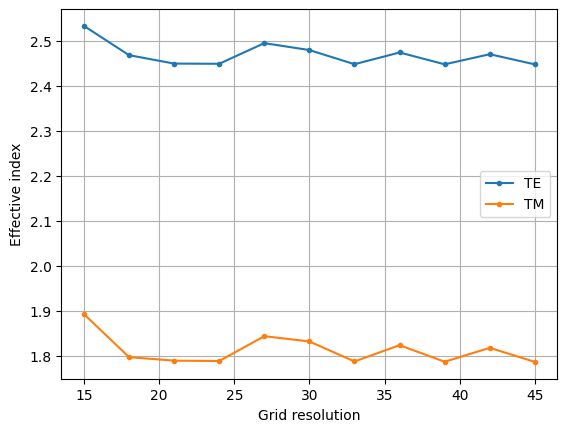

In [24]:
_, ax = pyplot.subplots(1, 1)
ax.plot(grid_resolution, n_eff, ".-")
ax.legend(["TE", "TM"])
ax.set(xlabel="Grid resolution", ylabel="Effective index")
ax.grid()

Note that even for higher resolutions, the local mode solver will still oscillate around the best esimate. That's an effect of the grid discretization of the simulation domain, which varies with the resolution. For the best results, the [server-side mode solver](../ModeSolver.html#Storing-server-side-computed-modes) should be prefered.